## Assignment 1: Comparisson of Tests for Goodness of fit

This notebook presents a series of tests in which we try to find if particular distributions (Gaussian, Poisson, Chisq) are a sensible model for the age distribution of citibike drivers.

The notebook reuses a big portion of the data acquisition, transformations and plotting logic from fedheres skeleton notebook for HW4 (https://github.com/fedhere/PUI2016_fb55/blob/master/HW4_fb55/citibikes_compare_distributions.ipynb)

In [38]:
# Standard imports to work with datasets, plots, distributions, etc.
import pylab as pl
import pandas as pd
import numpy as np
import os

# We will use Citibike Data-> will import Fededrica's download helper function
from getCitiBikeCSV import getCitiBikeCSV

# we will use np.random to generate the different distributions to test against
# I am setting the seed for reproducibility
np.random.seed(212)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [40]:
# Get the Citbike data (will use the same month as with the HW4)
datestring = '201501'
getCitiBikeCSV(datestring)

('Downloading', '201501')
file in place, you can continue


In [186]:
# Load the data into a dataframe and performing the basic data wrangling
df = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')

#Using Fedhere's age and gender data organization
df['age'] = 2015 - df['birth year'][(df['usertype'] == 'Subscriber')]

#dropping data no longer need for this study
df = df[['age']].copy()
# dropping NaN values
df['age'].dropna(inplace= True)

print (len(df))
print (df.age.mean())
print (df.age.std())
df.head()

285552
40.0485810434
11.5746367124


,age
0,55.0
1,52.0
2,41.0
3,46.0
4,38.0


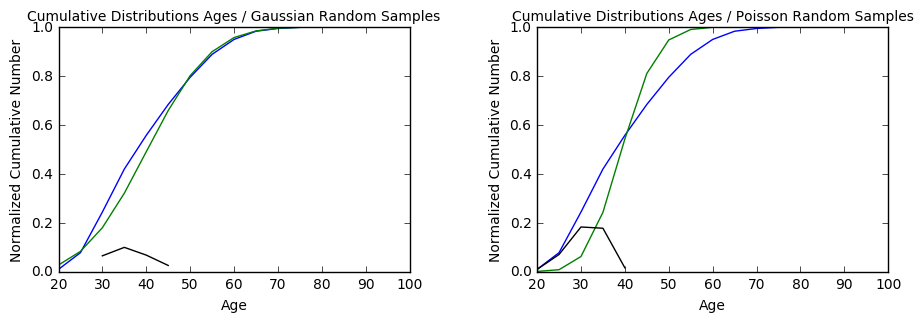

In [197]:
#Define the bins
#define bins for ages (from 10 to 99, 5 years)
bins = np.arange(15, 99, 5)

#Generate the cummulative distributions for age 
#http://www.itl.nist.gov/div898/handbook/eda/section3/eda35f.htm
#The group by along with the cumsim will get the cumulative count for each of the bins
cs=df.age.groupby(pd.cut(df.age, bins)).agg([count_nonzero]).cumsum()

# Generate a gaussian distribution with the same number of samples as the citibike df non-null ages (279924)
# Will define the distribution with a mean of 40 and standard deviation of 15
dfNorm = pd.DataFrame(data=np.random.normal(40.0485810434,11.5746367124,size=279924))

# Generate a poisson distribution with the same number of samples as the citibike df non-null ages (279924)
# Will define the distribution with a mean of 40
dfPoiss = pd.DataFrame(data=np.random.poisson(40,size=279924))

#The chi-square goodness-of-fit test is applied to binned data (i.e., data put into classes). 
#As we will be testing it agains a Gaussian (non-binned/ continuous data)  we will calculate a frequency table 
csSampleNorm=dfNorm[0].groupby(pd.cut(dfNorm[0], bins)).agg([count_nonzero]).cumsum()

csSamplePoiss=dfPoiss[0].groupby(pd.cut(dfPoiss[0], bins)).agg([count_nonzero]).cumsum()

#To get the frequency table we will get the percentage over the total for each of the bins
#print (cs)
#print (np.abs(cs / cs.max()))

pl.figure(figsize=(10, 4))
pl.subplot(121)
pl.title('Cumulative Distributions Ages / Gaussian Random Samples',fontsize = 10)
pl.plot(bins[:-1] + 5, cs / cs.max(), label = "Age")
pl.plot(bins[:-1] + 5, csSampleNorm / csSampleNorm.max(), label = "Sample")
pl.plot(bins[:-1] + 5, np.sqrt(cs / cs.max() - csSampleNorm / csSampleNorm.max())**2, 'k-',
        label = "difference")
pl.xlabel("Age")
pl.ylabel("Normalized Cumulative Number")
pl.subplot(122)
pl.title('Cumulative Distributions Ages / Poisson Random Samples',fontsize = 10)
pl.plot(bins[:-1] + 5, cs / cs.max(), label = "Age")
pl.plot(bins[:-1] + 5, csSamplePoiss / csSamplePoiss.max(), label = "Sample")
pl.plot(bins[:-1] + 5, np.sqrt(cs / cs.max() - csSamplePoiss / csSamplePoiss.max())**2, 'k-',
        label = "difference")
pl.xlabel("Age")
pl.ylabel("Normalized Cumulative Number")
pl.tight_layout(pad=3.5)


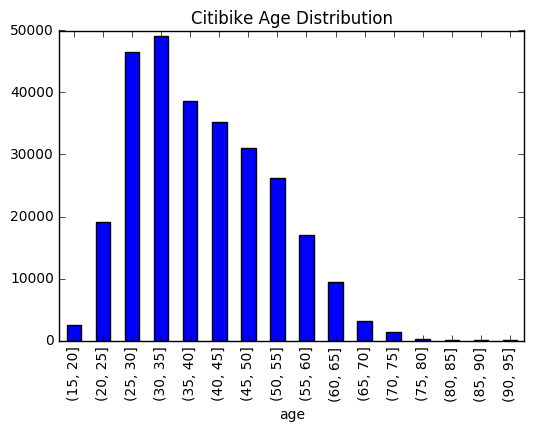

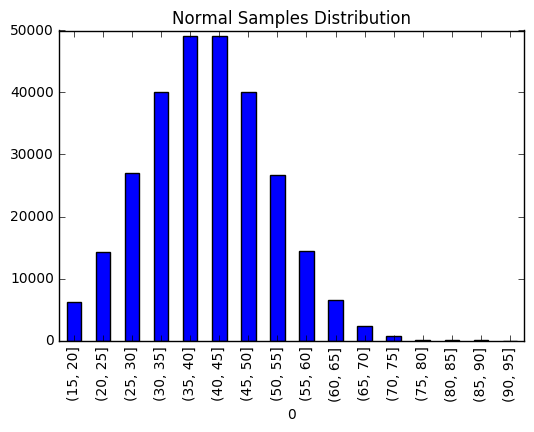

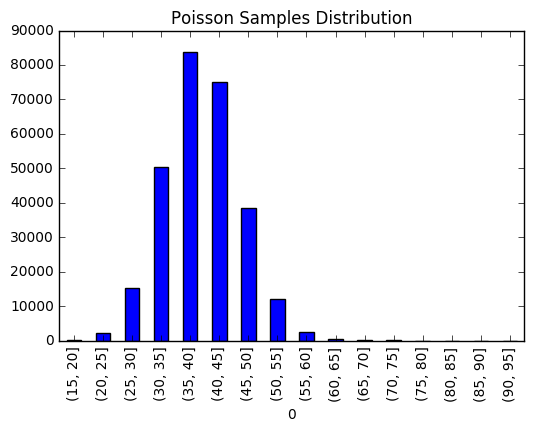

In [188]:
#Plotting the histograms, another "nice" visual comparison of the distributions

axCitiRiders = df.age.groupby(pd.cut(df.age, bins)).agg([count_nonzero]).plot(kind='bar', 
                                                                              legend=False)
axCitiRiders.set_title("Citibike Age Distribution")

axSamplesNormal = dfNorm[0].groupby(pd.cut(dfNorm[0], bins)).agg([count_nonzero]).plot(kind='bar',
                                                                                 legend=False)
axSamplesNormal.set_title("Normal Samples Distribution")

axSamplesPoisson = dfPoiss[0].groupby(pd.cut(dfPoiss[0], bins)).agg([count_nonzero]).plot(kind='bar',
                                                                                 legend=False)
axSamplesPoisson.set_title("Poisson Samples Distribution")

In [210]:
# Perform the Chisq comparisson
# http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html
# We will use the citibike ages as the f_obs (Observed frequencies on the categories) when invoking the function
# We will use the binned Gaussian Sample as the f_exp parameter (The expected frequencies on each category)
# We will use number of bins - 1 as the Delta Degrees of Freedom (ddof)
import scipy, scipy.stats
 
freqAges = np.abs(cs / cs.max())
freqSamples = np.abs(csSampleNorm / csSampleNorm.max())

#print (freqAges)
#print (freqSamples) 
#freqAges.head()


f_exp_norm = dfNorm[0].groupby(pd.cut(dfNorm[0], bins)).agg([count_nonzero])
f_exp_poiss = dfPoiss[0].groupby(pd.cut(dfPoiss[0], bins)).agg([count_nonzero])
f_obs = df.age.groupby(pd.cut(df.age, bins)).agg([count_nonzero])

chisqstatNorm=scipy.stats.chisquare(f_obs=f_obs.count_nonzero, f_exp=f_exp_norm.count_nonzero)
chisqstatPoiss=scipy.stats.chisquare(f_obs=f_obs.count_nonzero, f_exp=f_exp_poiss.count_nonzero)

print ("chisq for Normal Distribution matching")
print (chisqstatNorm)
print ("chisq for Poisson Distribution matching: ")
print (chisqstatPoiss)

chisq for Normal Distribution matching
Power_divergenceResult(statistic=28163.863806773639, pvalue=0.0)
chisq for Poisson Distribution matching: 
Power_divergenceResult(statistic=inf, pvalue=0.0)


#### The chisq statistic value of 24349.51 is significantly higher than 25, which is the critical X2 value for 15 degrees of freedom and a significance level of 0.05

#### do we reject the null hypothesis!?